In [ ]:
!pip install tensorflow==1.15
!pip install tensorflow_hub==0.11.0

     |████████████████████████████████| 412.3 MB 27 kB/s 
     |████████████████████████████████| 3.8 MB 38.3 MB/s 
     |████████████████████████████████| 503 kB 44.3 MB/s 
     |████████████████████████████████| 50 kB 6.6 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=4180186d9f42fb365e0fefcfa3649430055b97c2079f02fd4c6f97e7eeca7c34
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Succes

In [ ]:
pip install -U numpy==1.18.5

     |████████████████████████████████| 20.1 MB 682 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-probability 0.16.0 requires gast>=0.3.2, but you have gast 0.2.2 which is incompatible.
tables 3.7.0 requires numpy>=1.19.0, but you have numpy 1.18.5 which is incompatible.
kapre 0.3.7 requires tensorflow>=2.0.0, but you have tensorflow 1.15.0 which is incompatible.
jaxlib 0.3.2+cuda11.cudnn805 requires numpy>=1.19, but you have numpy 1.18.5 which is incompatible.
jax 0.3.4 requires numpy>=1.19, but you have numpy 1.18.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you hav

In [ ]:
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow.keras.backend as K
# import keras
# import html
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
gpu = tf.config.experimental.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
test = pd.read_csv('drugsComTest_raw.tsv', sep='\t')
train = pd.read_csv('drugsComTrain_raw.tsv', sep='\t')

In [ ]:
# test['rating'].value_counts().sort_index()

In [ ]:
def get_sentiment(rating):
  if rating < 4.0:
    
    return 'neg'
  elif rating >= 4.0 and rating <= 7.0:
    return 'neutral'
  else:
    return 'pos'


train['sentiment'] = train['rating'].map(lambda x: get_sentiment(x))
test['sentiment'] = test['rating'].map(lambda x: get_sentiment(x))

# encode class names to integers
labelencoder = LabelEncoder()
train['sentiment_encoded'] = labelencoder.fit_transform(train['sentiment'])
test['sentiment_encoded'] = labelencoder.fit_transform(test['sentiment'])


# train_df = train[:10000]

X_train, X_val, y_train, y_val = train_test_split(train['review'], train['sentiment_encoded'], train_size=0.8, random_state=1)

In [ ]:
# all_reviews.head()
print(train.shape)
print(test.shape)

(161297, 9)
(53766, 9)


### Extract ELMO Embeddings

#### Testing loading the elmo v2 model from tf_hub

In [ ]:
elmo_model = hub.load("https://tfhub.dev/google/elmo/2")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


#### Now preprocess data before getting embeddings for the text in the dataset

In [ ]:
sw_set = set(stopwords.words('english'))

In [ ]:
all_reviews['reviews_cleaned'] = all_reviews['review'].apply(lambda x: ' '.join([word for word in str(x).lower().split() if word.isascii() and word not in sw_set][:50]))

NameError: ignored

In [ ]:
all_reviews.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,sentiment,reviews_cleaned
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27,pos,"""it side effect, take combination bystolic 5 m..."
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192,pos,"""my son halfway fourth week intuniv. became co..."
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17,neutral,"""i used take another oral contraceptive, 21 pi..."
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10,pos,"""this first time using form birth control. i&#..."
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37,pos,"""suboxone completely turned life around. feel ..."


Need to get max sentence length and pad sequences:

In [ ]:
#Computing Max sentence length in order to enable padding

# reviews_train, reviews_test, labels_train, labels_test = train_test_split(all_reviews['reviews_cleaned'], all_reviews['sentiment'], random_state=1)

MAX_SEQUENCE_LENGTH = 50

#Padding Function Definition
def pad(e, sentence_length=MAX_SEQUENCE_LENGTH):
    # https://stackoverflow.com/questions/35751306/python-how-to-pad-numpy-array-with-zeros
    num_sentences, old_sentence_length, embedding_length = e.shape
    e2 = np.zeros((num_sentences, sentence_length, embedding_length))
    if old_sentence_length > sentence_length:
      e = e[:,:sentence_length,:]
      old_sentence_length = sentence_length
    e2[:, :old_sentence_length, :] = e
    return e2



# Xtrain = pad_sequences(reviews_train.tolist(), maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='pre')
# Xtest = pad_sequences(reviews_test.tolist(), maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='pre')


In [ ]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.compat.v1.global_variables_initializer())  
    session.run(tf.compat.v1.tables_initializer())

    all_embeddings = list()
    step = 64
    for i in range(int(len(X_val[:128])/step)+1):
        left = i*step
        right = (i+1)*step
        this_x = X_val[:128][left:right]

        # due to the +1 in the range(...+1), we can end up
        # with an empty row at the end. just skip it.
        if not this_x.any():
            continue

        embeddings = elmo_model.signatures['default'](tf.constant(this_x))["elmo"]
        print(embeddings.shape)
        e = session.run(embeddings)
        print(e.shape)
        e = pad(e)
        all_embeddings.append(e)
    all_embeddings = np.concatenate(all_embeddings)
    all_embeddings.shape

(?, ?, 1024)
(64, 191, 1024)
(?, ?, 1024)
(64, 243, 1024)


### Prep data

In [ ]:
sw_set = set(stopwords.words('english'))

In [ ]:
# reviews_train, reviews_test, labels_train, labels_test = train_test_split(all_reviews['reviews_cleaned'], all_reviews['sentiment'], random_state=1)

X_train_no_sw = X_train.apply(lambda x: ' '.join([word for word in str(x).lower().split() if word.isascii() and word not in sw_set][:50]))
X_val_no_sw = X_val.apply(lambda x: ' '.join([word for word in str(x).lower().split() if word.isascii() and word not in sw_set][:50]))
X_train = X_train.apply(lambda x: ' '.join([word for word in str(x).lower().split() if word.isascii()][:50]))
X_val = X_val.apply(lambda x: ' '.join([word for word in str(x).lower().split() if word.isascii() ][:50]))
test['reviews_cleaned'] = test['review'].apply(lambda x: ' '.join([word for word in str(x).lower().split() if word.isascii() and word not in sw_set][:50]))
# reviews_train = train['reviews_cleaned']
# reviews_test = test['reviews_cleaned']

# labels_train = train['sentiment']
labels_test = test['sentiment_encoded']

In [ ]:
X_test = test['review'].apply(lambda x: ' '.join([word for word in str(x).lower().split() if word.isascii()][:50]))

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling1D
from tensorflow.keras.models import Model

# import keras

In [ ]:
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical

# # encode class names to integers
# labelencoder = preprocessing.LabelEncoder()
# labels_train = labelencoder.fit_transform(labels_train)
# labels_test = labelencoder.fit_transform(labels_test)

ytrain = to_categorical(y_train)
yval = to_categorical(y_val)
# ydev = to_categorical(labels_val.values)
ytest = to_categorical(labels_test)

In [ ]:
def ELMoEmbedding(x):
    # return elmo_model(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]
    return elmo_model.signatures['default'](tf.constant(x))["elmo"]["default"] 


from cachetools import TTLCache,cached
cache = TTLCache(maxsize=100, ttl=21600)

@cached(cache)
def ELMoEmbeddingTrainable(x):
    return elmo_model.signatures['default'](tf.squeeze(tf.cast(x, tf.string)))["elmo"] 

In [ ]:

# from tensorflow.keras import layers
import tensorflow.keras.backend as K

# input_text = Input(shape=(1,))
input_text = Input(shape=(1,), dtype=tf.string)
embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
# pooled = GlobalAveragePooling1D()(embedding)
dense = Dense(128, activation='relu')(embedding)
pred = Dense(3, activation='softmax')(dense)
model = Model(inputs=input_text, outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
print(model.summary())


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
lambda (Lambda)              (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               131200    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 131,587
Trainable params: 131,587
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# NON-trainable elmo + feedforward

with tf.Session() as session:
    K.set_session(session)
    session.run(tf.compat.v1.global_variables_initializer())  
    session.run(tf.compat.v1.tables_initializer())
    history = model.fit(reviews_train[:2000], ytrain[:2000], epochs=20, batch_size=128)
    model.save_weights('./response-elmo-model.h5')


Train on 2000 samples
Epoch 1/20
2000/2000 [==============================] - 586s 293ms/sample - loss: 0.9634 - categorical_accuracy: 0.5970
Epoch 2/20
2000/2000 [==============================] - 574s 287ms/sample - loss: 0.9040 - categorical_accuracy: 0.6065
Epoch 3/20
2000/2000 [==============================] - 547s 274ms/sample - loss: 0.8808 - categorical_accuracy: 0.6160
Epoch 4/20
2000/2000 [==============================] - 540s 270ms/sample - loss: 0.8653 - categorical_accuracy: 0.6220
Epoch 5/20
2000/2000 [==============================] - 542s 271ms/sample - loss: 0.8418 - categorical_accuracy: 0.6230
Epoch 6/20
2000/2000 [==============================] - 538s 269ms/sample - loss: 0.8245 - categorical_accuracy: 0.6240
Epoch 7/20
2000/2000 [==============================] - 539s 269ms/sample - loss: 0.8128 - categorical_accuracy: 0.6410
Epoch 8/20
2000/2000 [==============================] - 537s 269ms/sample - loss: 0.7986 - categorical_accuracy: 0.6390
Epoch 9/20
2000/20

In [ ]:
# training on more samples

with tf.Session() as session:
    K.set_session(session)
    session.run(tf.compat.v1.global_variables_initializer())  
    session.run(tf.compat.v1.tables_initializer())
    history = model.fit(reviews_train, ytrain, validation_split=0.1, epochs=10, batch_size=256)
    model.save_weights('./response-elmo-model.h5')

Train on 145167 samples, validate on 16130 samples
Epoch 1/10
145167/145167 [==============================] - 1535s 11ms/sample - loss: 0.8286 - categorical_accuracy: 0.6455 - val_loss: 0.7945 - val_categorical_accuracy: 0.6646
Epoch 2/10
145167/145167 [==============================] - 1536s 11ms/sample - loss: 0.7747 - categorical_accuracy: 0.6715 - val_loss: 0.7780 - val_categorical_accuracy: 0.6696
Epoch 3/10
145167/145167 [==============================] - 1536s 11ms/sample - loss: 0.7511 - categorical_accuracy: 0.6809 - val_loss: 0.7642 - val_categorical_accuracy: 0.6735
Epoch 4/10
145167/145167 [==============================] - 1532s 11ms/sample - loss: 0.7354 - categorical_accuracy: 0.6885 - val_loss: 0.7378 - val_categorical_accuracy: 0.6838
Epoch 5/10
145167/145167 [==============================] - 1526s 11ms/sample - loss: 0.7251 - categorical_accuracy: 0.6931 - val_loss: 0.7442 - val_categorical_accuracy: 0.6818
Epoch 6/10
145167/145167 [==============================] -

Add option for trainable embedddings

In [ ]:
# from tensorflow.keras import layers
import tensorflow.keras.backend as K

# input_text = Input(shape=(1,))
input_text = Input(shape=(1,), dtype=tf.string)
embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
# pooled = GlobalAveragePooling1D()(embedding)
dense = Dense(128, activation='relu')(embedding)
pred = Dense(3, activation='softmax')(dense)
model_nontrainable = Model(inputs=input_text, outputs=pred)
model_nontrainable.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
lambda (Lambda)              (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               131200    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 131,587
Trainable params: 131,587
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.compat.v1.global_variables_initializer())  
    session.run(tf.compat.v1.tables_initializer())
    history = model.fit(reviews_train[:10000], ytrain[:10000], validation_split=0.2, epochs=5, batch_size=64)
    model_nontrainable.save_weights('./response-elmo-model.h5')

Train on 8000 samples, validate on 2000 samples
Epoch 1/5
8000/8000 [==============================] - 128s 16ms/sample - loss: 0.9326 - categorical_accuracy: 0.6025 - val_loss: 0.8704 - val_categorical_accuracy: 0.6210
Epoch 2/5
8000/8000 [==============================] - 117s 15ms/sample - loss: 0.8602 - categorical_accuracy: 0.6244 - val_loss: 0.8540 - val_categorical_accuracy: 0.6210
Epoch 3/5
8000/8000 [==============================] - 116s 15ms/sample - loss: 0.8347 - categorical_accuracy: 0.6399 - val_loss: 0.8383 - val_categorical_accuracy: 0.6395
Epoch 4/5
8000/8000 [==============================] - 116s 15ms/sample - loss: 0.8145 - categorical_accuracy: 0.6467 - val_loss: 0.8098 - val_categorical_accuracy: 0.6575
Epoch 5/5
8000/8000 [==============================] - 116s 14ms/sample - loss: 0.7963 - categorical_accuracy: 0.6625 - val_loss: 0.8101 - val_categorical_accuracy: 0.6560


In [ ]:
# from tensorflow.keras import layers
import tensorflow.keras.backend as K

# input_text = Input(shape=(1,))
input_text = Input(shape=(1,), dtype=tf.string)
embedding = Lambda(ELMoEmbeddingTrainable, output_shape=(1024, ))(input_text)
pooled = GlobalAveragePooling1D()(embedding)
dense = Dense(128, activation='relu')(pooled)
pred = Dense(3, activation='softmax')(dense)
model_trainable = Model(inputs=input_text, outputs=pred)
model_trainable.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
print(model_trainable.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
lambda_3 (Lambda)            (None, None, 1024)        0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 387       
Total params: 131,587
Trainable params: 131,587
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
input_text = Input(shape=(1,), dtype=tf.string)
embedding = Lambda(ELMoEmbeddingTrainable, output_shape=(1024, ))(input_text)
pooled = GlobalAveragePooling1D()(embedding)
dense = Dense(128, activation='relu')(pooled)
pred = Dense(3, activation='softmax')(dense)
model_trainable = Model(inputs=input_text, outputs=pred)
model_trainable.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
print(model_trainable.summary())

with tf.Session() as session:
    K.set_session(session)
    session.run(tf.compat.v1.global_variables_initializer())  
    session.run(tf.compat.v1.tables_initializer())
    history = model_trainable.fit(X_train[:10000], ytrain[:10000], validation_split=0.2, epochs=5, batch_size=64)
    model_trainable.save_weights('./elmo-model-trainable.h5')
    model_pred = model_trainable.predict(X_test[:2000], batch_size=128)
    model_pred_labels = np.argmax(model_pred, axis=1)
    # Conv_model_rand_embed_pred_labels[:10]

    y_test_labels = np.argmax(ytest[:2000], axis=1)
    # y_test_labels[:10]

    print(classification_report(y_test_labels, model_pred_labels, target_names=labelencoder.classes_))

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
lambda_4 (Lambda)            (None, None, 1024)        0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 387       
Total params: 131,587
Trainable params: 131,587
Non-trainable params: 0
_________________________________________________________________
None
Train on 8000 samples, validate on 2000 samples
Epoch 1/5
8000/8000 [==============================] - 125s 16ms/s

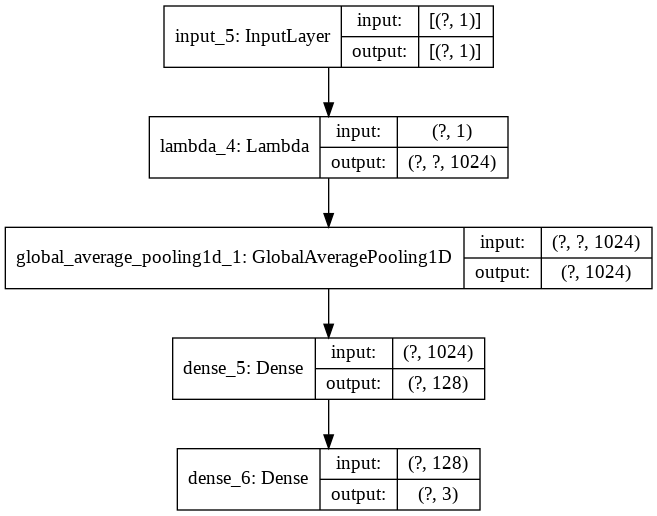

In [ ]:
tf.keras.utils.plot_model(model_trainable, to_file='trainable_model.png' , show_shapes=True)

In [ ]:
# from tensorflow.keras import layers
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers

# input_text = Input(shape=(1,))
input_text = Input(shape=(1,), dtype=tf.string)
embedding = Lambda(ELMoEmbeddingTrainable, output_shape=(1024, ))(input_text)
pooled = GlobalAveragePooling1D()(embedding)
dense = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(pooled)
pred = Dense(3, activation='softmax')(dense)
model_trainable = Model(inputs=input_text, outputs=pred)
model_trainable.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
print(model_trainable.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
lambda_3 (Lambda)            (None, None, 1024)        0         
_________________________________________________________________
global_average_pooling1d_3 ( (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 387       
Total params: 131,587
Trainable params: 131,587
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.compat.v1.global_variables_initializer())  
    session.run(tf.compat.v1.tables_initializer())
    # history = model_trainable.fit(X_train_no_sw[:10000], ytrain[:10000], validation_data=(X_val_no_sw[:2000], yval[:2000]), epochs=5, batch_size=64)
    history = model_trainable.fit(X_train[:10000], ytrain[:10000], validation_data=(X_val[:2000], yval[:2000]), epochs=5, batch_size=64)
    model_trainable.save_weights('./elmo-model-trainable.h5')

Train on 10000 samples, validate on 2000 samples
Epoch 1/5
10000/10000 [==============================] - 144s 14ms/sample - loss: 0.9174 - categorical_accuracy: 0.6099 - val_loss: 0.8861 - val_categorical_accuracy: 0.6405
Epoch 2/5
10000/10000 [==============================] - 140s 14ms/sample - loss: 0.8743 - categorical_accuracy: 0.6259 - val_loss: 0.8812 - val_categorical_accuracy: 0.6325
Epoch 3/5
10000/10000 [==============================] - 140s 14ms/sample - loss: 0.8461 - categorical_accuracy: 0.6409 - val_loss: 0.8437 - val_categorical_accuracy: 0.6530
Epoch 4/5
10000/10000 [==============================] - 140s 14ms/sample - loss: 0.8245 - categorical_accuracy: 0.6520 - val_loss: 0.8410 - val_categorical_accuracy: 0.6470
Epoch 5/5
10000/10000 [==============================] - 140s 14ms/sample - loss: 0.8122 - categorical_accuracy: 0.6578 - val_loss: 0.8331 - val_categorical_accuracy: 0.6630


In [ ]:
# not reproducible for evaluating
def evaluate_model(model_obj):

  with tf.Session() as session:
      K.set_session(session)
      session.run(tf.compat.v1.global_variables_initializer())  
      session.run(tf.compat.v1.tables_initializer())
      
      # evaluate_model code:
      model_pred = model_obj.predict(test['reviews_cleaned'][:2000], batch_size=16)
      model_pred_labels = np.argmax(model_pred, axis=1)
      # Conv_model_rand_embed_pred_labels[:10]

      y_test_labels = np.argmax(ytest[:2000], axis=1)
      # y_test_labels[:10]

      print(classification_report(y_test_labels, model_pred_labels, target_names=labelencoder.classes_))

In [ ]:
evaluate_model(model_trainable)

              precision    recall  f1-score   support

         neg       0.25      0.29      0.27       446
     neutral       0.00      0.00      0.00       348
         pos       0.61      0.75      0.67      1206

    accuracy                           0.52      2000
   macro avg       0.29      0.35      0.32      2000
weighted avg       0.42      0.52      0.47      2000



### Trying on CNN Model

In [ ]:
import pandas as pd
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling1D, GlobalMaxPooling1D, Dropout, Conv1D, Concatenate, LSTM, Bidirectional
from tensorflow.keras.models import Model
from sklearn.metrics import precision_recall_fscore_support
# from tensorflow.keras.layers.merge import Concatenate


In [ ]:
class Metrics(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.f1s = 0
    def on_epoch_end(self, batch, logs={}):
        predict = np.asarray(self.model.predict(self.validation_data[0])).argmax(axis=1)
        targ = self.validation_data[1].argmax(axis=1)
        #f1 = f1_score(targ, predict, average='micro')
        mtrcs = precision_recall_fscore_support(targ, predict, average='macro')
        print ("\nPrecision: "+str(mtrcs[0])+"\tRecall: "+str(mtrcs[1])+"\tF1: "+str(mtrcs[2]))
        if (self.f1s < mtrcs[2]):
            self.f1s = mtrcs[2]
            #self.model.save('./model/CNN_static_twitterGeneral_Best_EMRS_model_f1_.hdf5')
            #print("Modelo guardado\n")
        return

In [ ]:
def build_model(w2v_trainable=False):
    # num_words = len(tokenizer.word_index)+1

    input_text = Input(shape=(1,), dtype=tf.string)
    embedding = Lambda(ELMoEmbeddingTrainable, output_shape=(1024, ))(input_text)
    drop_out_1 = Dropout(0.3, name='drop_out_1')(embedding)
    conv_1 = Conv1D(64, 2, activation='relu', name='conv_1')(drop_out_1)
    gmp_1 = GlobalMaxPooling1D(name='gmp_1')(conv_1)
    conv_2 = Conv1D(64, 3, activation='relu', name='conv_2')(drop_out_1)
    gmp_2 = GlobalMaxPooling1D(name='gmp_2')(conv_2)
    conv_3 = Conv1D(64, 5, activation='relu', name='conv_3')(drop_out_1)
    gmp_3 = GlobalMaxPooling1D(name='gmp_3')(conv_3)

    concat = Concatenate()([gmp_1,gmp_2,gmp_3])
    drop_out_2 = Dropout(0.3, name='drop_out_2')(concat)
    mp_dense = Dense(128, activation='relu', name='mp_dense')(drop_out_2)

    pred = Dense(3, activation='softmax')(mp_dense)
    model_cnn = Model(inputs=input_text, outputs=pred)

    model_cnn.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

    metrics = Metrics()

    callbacks_list = [metrics]

    return model_cnn, callbacks_list

In [ ]:
BATCH_SIZE = 128
N_EPOCHS = 10

cnn_elmo, callbacks_list_cnn_elmo = build_model()

with tf.Session() as session:
    K.set_session(session)
    session.run(tf.compat.v1.global_variables_initializer())  
    session.run(tf.compat.v1.tables_initializer())
    history = cnn_elmo.fit(X_train[:10000], ytrain[:10000],
      #class_weight=class_weight_dict,
      shuffle=True,
      batch_size=BATCH_SIZE,
      epochs=N_EPOCHS,
    #   callbacks=callbacks_list_rand_embed,
      validation_data=(X_val[:2000], yval[:2000]))
    
    cnn_elmo.save_weights('./elmo-model-cnn.h5')




Train on 10000 samples, validate on 2000 samples
Epoch 1/10
10000/10000 [==============================] - 120s 12ms/sample - loss: 1.0973 - acc: 0.5649 - val_loss: 0.8930 - val_acc: 0.6100
Epoch 2/10
10000/10000 [==============================] - 116s 12ms/sample - loss: 0.8808 - acc: 0.6200 - val_loss: 0.8336 - val_acc: 0.6400
Epoch 3/10
10000/10000 [==============================] - 117s 12ms/sample - loss: 0.8088 - acc: 0.6539 - val_loss: 0.8209 - val_acc: 0.6505
Epoch 4/10
10000/10000 [==============================] - 116s 12ms/sample - loss: 0.7611 - acc: 0.6764 - val_loss: 0.7853 - val_acc: 0.6690
Epoch 5/10
10000/10000 [==============================] - 116s 12ms/sample - loss: 0.7029 - acc: 0.7016 - val_loss: 0.7809 - val_acc: 0.6570
Epoch 6/10
10000/10000 [==============================] - 116s 12ms/sample - loss: 0.6753 - acc: 0.7127 - val_loss: 0.7746 - val_acc: 0.6560
Epoch 7/10
10000/10000 [==============================] - 116s 12ms/sample - loss: 0.5986 - acc: 0.7489 -

In [ ]:
def evaluate_model(model_obj): 
    # Get predictions with validation set 
    model_pred = model_obj.predict(test['reviews_cleaned'][:2000], batch_size=16)
    model_pred_proba = [float(x[1]) for x in tf.nn.softmax(model_pred)]
    model_pred_label = [0 if x[0] > x[1] else 1 for x in tf.nn.softmax(model_pred)]

    model_pred_labels = np.argmax(model_pred, axis=1)
    # Conv_model_rand_embed_pred_labels[:10]

    y_test_labels = np.argmax(ytest, axis=1)
    # y_test_labels[:10]

    print(classification_report(y_test_labels, model_pred_labels, target_names=labelencoder.classes_))

In [ ]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.compat.v1.global_variables_initializer())  
    session.run(tf.compat.v1.tables_initializer())
    evaluate_model(cnn_elmo)

OperatorNotAllowedInGraphError: ignored

In [ ]:
BATCH_SIZE = 256
N_EPOCHS = 15

cnn_elmo2, callbacks_list_cnn_elmo2 = build_model()

with tf.Session() as session:
    K.set_session(session)
    session.run(tf.compat.v1.global_variables_initializer())  
    session.run(tf.compat.v1.tables_initializer())
    history = cnn_elmo2.fit(X_train[:10000], ytrain[:10000],
      #class_weight=class_weight_dict,
      shuffle=True,
      batch_size=BATCH_SIZE,
      epochs=N_EPOCHS,
    #   callbacks=callbacks_list_rand_embed,
      validation_data=(X_val, yval))
    
    cnn_elmo2.save_weights('./elmo-model-cnn2.h5')

Train on 8000 samples, validate on 2000 samples
Epoch 1/15
8000/8000 [==============================] - 55s 7ms/sample - loss: 1.1313 - acc: 0.5412 - val_loss: 0.9331 - val_acc: 0.6040
Epoch 2/15
8000/8000 [==============================] - 50s 6ms/sample - loss: 0.9170 - acc: 0.6024 - val_loss: 0.8890 - val_acc: 0.6380
Epoch 3/15
8000/8000 [==============================] - 50s 6ms/sample - loss: 0.8654 - acc: 0.6240 - val_loss: 0.8661 - val_acc: 0.6415
Epoch 4/15
8000/8000 [==============================] - 51s 6ms/sample - loss: 0.8229 - acc: 0.6391 - val_loss: 0.8138 - val_acc: 0.6585
Epoch 5/15
8000/8000 [==============================] - 51s 6ms/sample - loss: 0.7687 - acc: 0.6684 - val_loss: 0.7905 - val_acc: 0.6685
Epoch 6/15
8000/8000 [==============================] - 51s 6ms/sample - loss: 0.7191 - acc: 0.6884 - val_loss: 0.8165 - val_acc: 0.6390
Epoch 7/15
8000/8000 [==============================] - 52s 7ms/sample - loss: 0.6737 - acc: 0.7141 - val_loss: 0.7676 - val_acc: 

In [ ]:
BATCH_SIZE = 128
N_EPOCHS = 10

cnn_elmo, callbacks_list_cnn_elmo = build_model()

with tf.Session() as session:
    K.set_session(session)
    session.run(tf.compat.v1.global_variables_initializer())  
    session.run(tf.compat.v1.tables_initializer())
    history = cnn_elmo.fit(X_train[:10000], ytrain[:10000],
      #class_weight=class_weight_dict,
      shuffle=True,
      batch_size=BATCH_SIZE,
      epochs=N_EPOCHS,
    #   callbacks=callbacks_list_rand_embed,
      validation_data=(X_val[:2000], yval[:2000]))
    
    cnn_elmo.save_weights('./elmo-model-cnn.h5')


Train on 10000 samples, validate on 2000 samples
Epoch 1/10
10000/10000 [==============================] - 120s 12ms/sample - loss: 0.9986 - acc: 0.5830 - val_loss: 0.8840 - val_acc: 0.6190
Epoch 2/10
10000/10000 [==============================] - 117s 12ms/sample - loss: 0.8637 - acc: 0.6302 - val_loss: 0.8222 - val_acc: 0.6500
Epoch 3/10
10000/10000 [==============================] - 116s 12ms/sample - loss: 0.7923 - acc: 0.6583 - val_loss: 0.8263 - val_acc: 0.6535
Epoch 4/10
10000/10000 [==============================] - 117s 12ms/sample - loss: 0.7452 - acc: 0.6781 - val_loss: 0.7907 - val_acc: 0.6510
Epoch 5/10
10000/10000 [==============================] - 116s 12ms/sample - loss: 0.6812 - acc: 0.7153 - val_loss: 0.7722 - val_acc: 0.6690
Epoch 6/10
10000/10000 [==============================] - 116s 12ms/sample - loss: 0.6331 - acc: 0.7357 - val_loss: 0.8225 - val_acc: 0.6370
Epoch 7/10
10000/10000 [==============================] - 119s 12ms/sample - loss: 0.5734 - acc: 0.7628 -

In [ ]:
def build_model2(w2v_trainable=False):
    # num_words = len(tokenizer.word_index)+1

    input_text = Input(shape=(1,), dtype=tf.string)
    embedding = Lambda(ELMoEmbeddingTrainable, output_shape=(1024, ))(input_text)
    drop_out_1 = Dropout(0.3, name='drop_out_1')(embedding)
    conv_1 = Conv1D(64, 2, activation='relu', name='conv_1')(drop_out_1)
    gmp_1 = GlobalMaxPooling1D(name='gmp_1')(conv_1)
    mp_dense = Dense(128, activation='relu', name='mp_dense')(gmp_1)

    pred = Dense(3, activation='softmax')(mp_dense)
    model_cnn = Model(inputs=input_text, outputs=pred)

    model_cnn.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

    # metrics = Metrics()

    # callbacks_list = [metrics]

    return model_cnn, None

In [ ]:
pip install -U numpy==1.18.5

     |████████████████████████████████| 20.1 MB 11.5 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-probability 0.16.0 requires gast>=0.3.2, but you have gast 0.2.2 which is incompatible.
tables 3.7.0 requires numpy>=1.19.0, but you have numpy 1.18.5 which is incompatible.
kapre 0.3.7 requires tensorflow>=2.0.0, but you have tensorflow 1.15.0 which is incompatible.
jaxlib 0.3.2+cuda11.cudnn805 requires numpy>=1.19, but you have numpy 1.18.5 which is incompatible.
jax 0.3.4 requires numpy>=1.19, but you have numpy 1.18.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you ha

#### LSTM

In [ ]:
# trying on LSTM

input_text = Input(shape=(1,), dtype=tf.string)
embedding = Lambda(ELMoEmbeddingTrainable, output_shape=(1024, ))(input_text)
lstm = LSTM(100, input_shape=(1024,))(embedding)
drop = Dropout(0.2)(lstm)
mp_dense = Dense(128, activation='relu', name='mp_dense')(drop)
pred = Dense(3, activation='softmax')(mp_dense)
model_lstm = Model(inputs=input_text, outputs=pred)

model_lstm.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

model_lstm.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
lambda_4 (Lambda)            (None, None, 1024)        0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               450000    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
mp_dense (Dense)             (None, 128)               12928     
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 387       
Total params: 463,315
Trainable params: 463,315
Non-trainable params: 0
_____________________________________________________

In [ ]:
BATCH_SIZE = 128
N_EPOCHS = 5


with tf.Session() as session:
    K.set_session(session)
    session.run(tf.compat.v1.global_variables_initializer())  
    session.run(tf.compat.v1.tables_initializer())
    history = model_lstm.fit(np.asarray(X_train[:20000]), ytrain[:20000],
      #class_weight=class_weight_dict,
      shuffle=True,
      batch_size=BATCH_SIZE,
      epochs=N_EPOCHS,
    #   callbacks=callbacks_list_rand_embed,
      validation_data=(np.asarray(X_val[:2000]), yval[:2000]))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 20000 samples, validate on 2000 samples
Epoch 1/5
20000/20000 [==============================] - 231s 12ms/sample - loss: 0.9429 - acc: 0.5979 - val_loss: 0.9214 - val_acc: 0.5975
Epoch 2/5
20000/20000 [==============================] - 227s 11ms/sample - loss: 0.8787 - acc: 0.6270 - val_loss: 0.8366 - val_acc: 0.6520
Epoch 3/5
20000/20000 [==============================] - 226s 11ms/sample - loss: 0.7923 - acc: 0.6702 - val_loss: 0.7679 - val_acc: 0.6770
Epoch 4/5
20000/20000 [==============================] - 228s 11ms/sample - loss: 0.7230 - acc: 0.7013 - val_loss: 0.7415 - val_acc: 0.6910
Epoch 5/5
20000/20000 [==============================] - 226s 11ms/sample - loss: 0.6509 - acc: 0.7329 - val_loss: 0.7473 - val_acc: 0.6930


##### LSTM Bidirectional

In [ ]:
##### 
input_text = Input(shape=(1,), dtype=tf.string)
embedding = Lambda(ELMoEmbeddingTrainable, output_shape=(1024, ))(input_text)
bidir = Bidirectional(LSTM(100, input_shape=(1024,),recurrent_dropout=0.2), name='BiLSTM')(embedding)
# lstm = LSTM(100, input_shape=(1024,))(embedding)
# drop = Dropout(0.2)(lstm)
mp_dense = Dense(256, activation='relu', name='mp_dense')(bidir)
pred = Dense(3, activation='softmax')(mp_dense)
model_lstm_bi = Model(inputs=input_text, outputs=pred)

model_lstm_bi.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])


BATCH_SIZE = 128
N_EPOCHS = 5


with tf.Session() as session:
    K.set_session(session)
    session.run(tf.compat.v1.global_variables_initializer())  
    session.run(tf.compat.v1.tables_initializer())
    history = model_lstm_bi.fit(np.asarray(X_train[:20000]), ytrain[:20000],
      #class_weight=class_weight_dict,
      shuffle=True,
      batch_size=BATCH_SIZE,
      epochs=N_EPOCHS,
    #   callbacks=callbacks_list_rand_embed,
      validation_data=(np.asarray(X_val[:2000]), yval[:2000]))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 20000 samples, validate on 2000 samples
Epoch 1/5
20000/20000 [==============================] - 263s 13ms/sample - loss: 0.8775 - acc: 0.6234 - val_loss: 0.8117 - val_acc: 0.6660
Epoch 2/5
20000/20000 [==============================] - 252s 13ms/sample - loss: 0.7626 - acc: 0.6773 - val_loss: 0.7486 - val_acc: 0.6900
Epoch 3/5
20000/20000 [==============================] - 252s 13ms/sample - loss: 0.6749 - acc: 0.7167 - val_loss: 0.7347 - val_acc: 0.6900
Epoch 4/5
20000/20000 [==============================] - 253s 13ms/sample - loss: 0.5757 - acc: 0.7627 - val_loss: 0.7723 - val_acc: 0.6835
Epoch 5/5
20000/20000 [==============================] - 252s 13ms/sample - loss: 0.4702 - acc: 0.8108 - val_loss: 0.8164 - val_acc: 0.7040


In [ ]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.compat.v1.global_variables_initializer())  
    session.run(tf.compat.v1.tables_initializer())
    model_lstm_bi.save_weights('model-lstm-bidir.h5')

In [ ]:
from tensorflow.keras.backend import manual_variable_initialization 
manual_variable_initialization(True)

with tf.Session() as session:
    K.set_session(session)
    session.run(tf.compat.v1.global_variables_initializer())  
    session.run(tf.compat.v1.tables_initializer())
    
    # model_lstm_bi.evaluate(X_val[:2000], yval[:2000],)

    # evaluate_model code:
    model_pred = model_lstm_bi.predict(test['reviews_cleaned'][:2000], batch_size=128)
    print(model_pred)

    model_pred_labels = np.argmax(model_pred, axis=1)
    # Conv_model_rand_embed_pred_labels[:10]

    y_test_labels = np.argmax(ytest[:2000], axis=1)
    # y_test_labels[:10]

    print(classification_report(y_test_labels, model_pred_labels, target_names=labelencoder.classes_))

[[0.2835501  0.32436496 0.3920849 ]
 [0.30833    0.32116342 0.37050658]
 [0.29334682 0.31264168 0.39401147]
 ...
 [0.22433487 0.3415663  0.43409887]
 [0.2584445  0.40417424 0.33738127]
 [0.29477504 0.3156128  0.38961217]]
              precision    recall  f1-score   support

         neg       0.23      0.02      0.03       446
     neutral       0.18      0.53      0.27       348
         pos       0.61      0.48      0.54      1206

    accuracy                           0.38      2000
   macro avg       0.34      0.34      0.28      2000
weighted avg       0.45      0.39      0.38      2000



In [ ]:
##### TRYING BIDIRECTIONAL 2.0
input_text = Input(shape=(1,), dtype=tf.string)
embedding = Lambda(ELMoEmbeddingTrainable, output_shape=(1024, ))(input_text)
bidir = Bidirectional(LSTM(100, input_shape=(1024,),recurrent_dropout=0.2), name='BiLSTM')(embedding)
# lstm = LSTM(100, input_shape=(1024,))(embedding)
# drop = Dropout(0.2)(lstm)
mp_dense = Dense(256, activation='relu', name='mp_dense')(bidir)
pred = Dense(3, activation='softmax')(mp_dense)
model_lstm_bi = Model(inputs=input_text, outputs=pred)

model_lstm_bi.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['categorical_accuracy'])


BATCH_SIZE = 128
N_EPOCHS = 25

from tensorflow.keras.callbacks import EarlyStopping

from google.colab import files



with tf.Session() as session:
    K.set_session(session)
    session.run(tf.compat.v1.global_variables_initializer())  
    session.run(tf.compat.v1.tables_initializer())
    early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
    history = model_lstm_bi.fit(np.asarray(X_train[:20000]), ytrain[:20000],
      #class_weight=class_weight_dict,
      shuffle=True,
      batch_size=BATCH_SIZE,
      epochs=N_EPOCHS,
      callbacks=[early_stopping],
      validation_data=(np.asarray(X_val[:2000]), yval[:2000]))
    model_lstm_bi.save_weights('model-lstm-bidir-early-stop.h5')
    files.download('model-lstm-bidir-early-stop.h5') 

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 20000 samples, validate on 2000 samples
Epoch 1/25
20000/20000 [==============================] - 255s 13ms/sample - loss: 0.8721 - categorical_accuracy: 0.6237 - val_loss: 0.8107 - val_categorical_accuracy: 0.6700
Epoch 2/25
20000/20000 [==============================] - 248s 12ms/sample - loss: 0.7629 - categorical_accuracy: 0.6735 - val_loss: 0.7483 - val_categorical_accuracy: 0.6895
Epoch 3/25
20000/20000 [==============================] - 248s 12ms/sample - loss: 0.6694 - categorical_accuracy: 0.7193 - val_loss: 0.7516 - val_categorical_accuracy: 0.6860
Epoch 4/25
20000/20000 [==============================] - 248s 12ms/sample - loss: 0.5771 - categorical_accuracy: 0.7616 - val_loss: 0.7529 - val_categorical_accuracy: 0.6920
Epoch 5/25
20000/20000 [==============================] - 248s 12ms/sample - loss: 0.4628 - categorical_accuracy: 0.8137 - val_loss: 0.8301 - val_categorical_accuracy: 0.6935


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
##### TRYING BIDIRECTIONAL 2.0
input_text = Input(shape=(1,), dtype=tf.string)
embedding = Lambda(ELMoEmbeddingTrainable, output_shape=(1024, ))(input_text)
bidir = Bidirectional(LSTM(100, input_shape=(1024,),recurrent_dropout=0.2), name='BiLSTM')(embedding)
# lstm = LSTM(100, input_shape=(1024,))(embedding)
# drop = Dropout(0.2)(lstm)
mp_dense = Dense(128, activation='relu', name='mp_dense')(bidir)
pred = Dense(3, activation='softmax')(mp_dense)
model_lstm_bi = Model(inputs=input_text, outputs=pred)

model_lstm_bi.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['categorical_accuracy'])


BATCH_SIZE = 128
N_EPOCHS = 25

from tensorflow.keras.callbacks import EarlyStopping

from google.colab import files



with tf.Session() as session:
    K.set_session(session)
    session.run(tf.compat.v1.global_variables_initializer())  
    session.run(tf.compat.v1.tables_initializer())
    early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
    history = model_lstm_bi.fit(np.asarray(X_train[:30000]), ytrain[:30000],
      #class_weight=class_weight_dict,
      shuffle=True,
      batch_size=BATCH_SIZE,
      epochs=N_EPOCHS,
      callbacks=[early_stopping],
      validation_data=(np.asarray(X_val[:2000]), yval[:2000]))
    model_lstm_bi.save_weights('model-lstm-bidir-early-stop.h5')
    files.download('model-lstm-bidir-early-stop.h5') 


    model_pred = model_lstm_bi.predict(X_test[:2000], batch_size=128)
    model_pred_labels = np.argmax(model_pred, axis=1)
    # Conv_model_rand_embed_pred_labels[:10]

    y_test_labels = np.argmax(ytest[:2000], axis=1)
    # y_test_labels[:10]

    print(classification_report(y_test_labels, model_pred_labels, target_names=labelencoder.classes_))

Train on 30000 samples, validate on 2000 samples
Epoch 1/25
30000/30000 [==============================] - 367s 12ms/sample - loss: 0.8627 - categorical_accuracy: 0.6307 - val_loss: 0.7953 - val_categorical_accuracy: 0.6745
Epoch 2/25
30000/30000 [==============================] - 363s 12ms/sample - loss: 0.7371 - categorical_accuracy: 0.6892 - val_loss: 0.7244 - val_categorical_accuracy: 0.6985
Epoch 3/25
30000/30000 [==============================] - 362s 12ms/sample - loss: 0.6464 - categorical_accuracy: 0.7300 - val_loss: 0.6931 - val_categorical_accuracy: 0.7190
Epoch 4/25
30000/30000 [==============================] - 363s 12ms/sample - loss: 0.5670 - categorical_accuracy: 0.7669 - val_loss: 0.7109 - val_categorical_accuracy: 0.7125
Epoch 5/25
30000/30000 [==============================] - 361s 12ms/sample - loss: 0.4685 - categorical_accuracy: 0.8093 - val_loss: 0.7464 - val_categorical_accuracy: 0.7095
Epoch 6/25
30000/30000 [==============================] - 361s 12ms/sample -

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

              precision    recall  f1-score   support

         neg       0.67      0.55      0.61       446
     neutral       0.40      0.15      0.22       348
         pos       0.74      0.92      0.82      1206

    accuracy                           0.71      2000
   macro avg       0.60      0.54      0.55      2000
weighted avg       0.67      0.71      0.67      2000



In [ ]:
##### TRYING BIDIRECTIONAL 3.0
from tensorflow.keras import regularizers

input_text = Input(shape=(1,), dtype=tf.string)
embedding = Lambda(ELMoEmbeddingTrainable, output_shape=(1024, ))(input_text)
bidir = Bidirectional(LSTM(100, input_shape=(1024,),recurrent_dropout=0.2, dropout=0.2), name='BiLSTM')(embedding)
# lstm = LSTM(100, input_shape=(1024,))(embedding)
# drop = Dropout(0.2)(lstm)
mp_dense = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4), name='mp_dense')(bidir)
drop = Dropout(0.2)(mp_dense)
pred = Dense(3, activation='softmax')(drop)
model_lstm_bi = Model(inputs=input_text, outputs=pred)

model_lstm_bi.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['categorical_accuracy'])


BATCH_SIZE = 128
N_EPOCHS = 25

from tensorflow.keras.callbacks import EarlyStopping

from google.colab import files



session = tf.Session()
K.set_session(session)
session.run(tf.compat.v1.global_variables_initializer())  
session.run(tf.compat.v1.tables_initializer())
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
history = model_lstm_bi.fit(np.asarray(X_train[:30000]), ytrain[:30000],
  #class_weight=class_weight_dict,
  shuffle=True,
  batch_size=BATCH_SIZE,
  epochs=N_EPOCHS,
  callbacks=[early_stopping],
  validation_data=(np.asarray(X_val[:2000]), yval[:2000]))
model_lstm_bi.save_weights('model-lstm-bidir-early-stop.h5')
files.download('model-lstm-bidir-early-stop.h5') 


model_pred = model_lstm_bi.predict(X_test[:2000], batch_size=128)
model_pred_labels = np.argmax(model_pred, axis=1)
# Conv_model_rand_embed_pred_labels[:10]

y_test_labels = np.argmax(ytest[:2000], axis=1)
# y_test_labels[:10]

print(classification_report(y_test_labels, model_pred_labels, target_names=labelencoder.classes_))

Train on 30000 samples, validate on 2000 samples
Epoch 1/25
30000/30000 [==============================] - 369s 12ms/sample - loss: 0.8896 - categorical_accuracy: 0.6250 - val_loss: 0.8180 - val_categorical_accuracy: 0.6650
Epoch 2/25
30000/30000 [==============================] - 365s 12ms/sample - loss: 0.7787 - categorical_accuracy: 0.6760 - val_loss: 0.7592 - val_categorical_accuracy: 0.6915
Epoch 3/25
30000/30000 [==============================] - 365s 12ms/sample - loss: 0.7122 - categorical_accuracy: 0.7055 - val_loss: 0.7235 - val_categorical_accuracy: 0.7080
Epoch 4/25
30000/30000 [==============================] - 364s 12ms/sample - loss: 0.6548 - categorical_accuracy: 0.7298 - val_loss: 0.7166 - val_categorical_accuracy: 0.7175
Epoch 5/25
30000/30000 [==============================] - 365s 12ms/sample - loss: 0.6044 - categorical_accuracy: 0.7534 - val_loss: 0.7184 - val_categorical_accuracy: 0.7165
Epoch 6/25
30000/30000 [==============================] - 364s 12ms/sample -

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

              precision    recall  f1-score   support

         neg       0.59      0.63      0.61       446
     neutral       0.39      0.17      0.23       348
         pos       0.77      0.87      0.82      1206

    accuracy                           0.70      2000
   macro avg       0.58      0.56      0.55      2000
weighted avg       0.66      0.70      0.67      2000



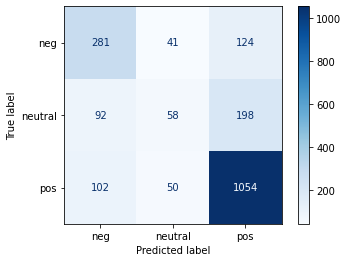

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test_labels, model_pred_labels, display_labels=labelencoder.classes_, cmap='Blues')

In [ ]:
BATCH_SIZE = 256
N_EPOCHS = 10


with tf.Session() as session:
    K.set_session(session)
    session.run(tf.compat.v1.global_variables_initializer())  
    session.run(tf.compat.v1.tables_initializer())
    history = model_lstm.fit(X_train[:80000], ytrain[:80000],
      #class_weight=class_weight_dict,
      shuffle=True,
      batch_size=BATCH_SIZE,
      epochs=N_EPOCHS,
    #   callbacks=callbacks_list_rand_embed,
      validation_data=(X_val[:2000], yval[:2000]))

Train on 80000 samples, validate on 2000 samples
Epoch 1/10
80000/80000 [==============================] - 778s 10ms/sample - loss: 0.8444 - acc: 0.6423 - val_loss: 0.7584 - val_acc: 0.6805
Epoch 2/10
80000/80000 [==============================] - 774s 10ms/sample - loss: 0.6976 - acc: 0.7085 - val_loss: 0.6860 - val_acc: 0.7135
Epoch 3/10
80000/80000 [==============================] - 773s 10ms/sample - loss: 0.6244 - acc: 0.7421 - val_loss: 0.6606 - val_acc: 0.7195
Epoch 4/10
80000/80000 [==============================] - 774s 10ms/sample - loss: 0.5569 - acc: 0.7717 - val_loss: 0.6510 - val_acc: 0.7350
Epoch 5/10
80000/80000 [==============================] - 773s 10ms/sample - loss: 0.4880 - acc: 0.8051 - val_loss: 0.6617 - val_acc: 0.7420
Epoch 6/10
80000/80000 [==============================] - 773s 10ms/sample - loss: 0.4130 - acc: 0.8400 - val_loss: 0.6523 - val_acc: 0.7540
Epoch 7/10
80000/80000 [==============================] - 772s 10ms/sample - loss: 0.3376 - acc: 0.8719 -

In [ ]:
BATCH_SIZE = 256
N_EPOCHS = 10

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience=2, restore_best_weights=True)

with tf.Session() as session:
    K.set_session(session)
    session.run(tf.compat.v1.global_variables_initializer())  
    session.run(tf.compat.v1.tables_initializer())
    history = model_lstm.fit(X_train[:100000], ytrain[:100000],
      #class_weight=class_weight_dict,
      shuffle=True,
      batch_size=BATCH_SIZE,
      epochs=N_EPOCHS,
      callbacks=[early_stopping],
    #   callbacks=callbacks_list_rand_embed,
      validation_data=(X_val[:2000], yval[:2000]))

Train on 100000 samples, validate on 2000 samples
Epoch 1/10
100000/100000 [==============================] - 979s 10ms/sample - loss: 0.8244 - acc: 0.6530 - val_loss: 0.7199 - val_acc: 0.6970
Epoch 2/10
100000/100000 [==============================] - 971s 10ms/sample - loss: 0.6799 - acc: 0.7180 - val_loss: 0.6707 - val_acc: 0.7195
Epoch 3/10
100000/100000 [==============================] - 971s 10ms/sample - loss: 0.6094 - acc: 0.7495 - val_loss: 0.6566 - val_acc: 0.7260
Epoch 4/10
100000/100000 [==============================] - 972s 10ms/sample - loss: 0.5450 - acc: 0.7778 - val_loss: 0.6607 - val_acc: 0.7185
Epoch 5/10
100000/100000 [==============================] - 976s 10ms/sample - loss: 0.4738 - acc: 0.8109 - val_loss: 0.6508 - val_acc: 0.7530
Epoch 6/10
100000/100000 [==============================] - 975s 10ms/sample - loss: 0.3990 - acc: 0.8446 - val_loss: 0.6556 - val_acc: 0.7545
Epoch 7/10
  4352/100000 [>.............................] - ETA: 15:13 - loss: 0.3016 - acc:

KeyboardInterrupt: ignored

### Evaluation

In [ ]:
import tensorflow.keras.backend as K

# input_text = Input(shape=(1,))
input_text = Input(shape=(1,), dtype=tf.string)
# embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
embedding = Lambda(ELMoEmbeddingTrainable, output_shape=(1024, ))(input_text)
pooled = GlobalAveragePooling1D()(embedding)
dense = Dense(128, activation='relu')(pooled)
pred = Dense(3, activation='softmax')(dense)

saved_model = Model(inputs=input_text, outputs=pred)
saved_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
print(saved_model.summary())



Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
lambda_6 (Lambda)            (None, None, 1024)        0         
_________________________________________________________________
global_average_pooling1d_2 ( (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 387       
Total params: 131,587
Trainable params: 131,587
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
!pip install 'h5py==2.10.0' --force-reinstall

     |████████████████████████████████| 2.9 MB 7.5 MB/s 
     |████████████████████████████████| 15.7 MB 43.3 MB/s 
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-probability 0.16.0 requires gast>=0.3.2, but you have gast 0.2.2 which is incompatible.
kapre 0.3.7 requires tensorflow>=2.0.0, but you have tensorflow 1.15.0 which is incompatible.
google-colab 1.0.0 requires six~=1.15.0, but you have six 1.16.0 which is inco

In [ ]:
# Restore the weights
saved_model.load_weights('./elmo_trained_on_default_embeddings.h5')
# saved_model.load_weights('./elmo-model-trainable.h5')
saved_model.summary()

RuntimeError: ignored

In [ ]:
with tf.Session() as session:
    K.set_session(session)
    # saved_model.load_weights('./elmo_trained_on_default_embeddings.h5')
    saved_model.load_weights('./elmo-model-trainable.h5')
    saved_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
lambda_6 (Lambda)            (None, None, 1024)        0         
_________________________________________________________________
global_average_pooling1d_2 ( (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 387       
Total params: 131,587
Trainable params: 131,587
Non-trainable params: 0
_________________________________________________________________


In [ ]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.compat.v1.global_variables_initializer())  
    session.run(tf.compat.v1.tables_initializer())
    
    # evaluate_model code:
    model_pred = saved_model.predict(test['reviews_cleaned'][:2000], batch_size=16)
    model_pred_labels = np.argmax(model_pred, axis=1)
    y_test_labels = np.argmax(ytest[:2000], axis=1)
    # y_test_labels[:10]

    print(classification_report(y_test_labels, model_pred_labels, target_names=labelencoder.classes_))

              precision    recall  f1-score   support

         neg       0.18      0.12      0.14       446
     neutral       0.23      0.27      0.25       348
         pos       0.61      0.65      0.63      1206

    accuracy                           0.46      2000
   macro avg       0.34      0.35      0.34      2000
weighted avg       0.45      0.46      0.45      2000



In [ ]:
saved_model.evaluate(reviews_test, ytest)

 980/1681 [================>.............] - ETA: 6:13 - loss: 0.8808 - categorical_accuracy: 0.6180

KeyboardInterrupt: ignored

Trying with Anne's saved model

In [ ]:
!pip install transformers
!pip install tensorflow

In [ ]:
from transformers import AutoTokenizer, AutoModel, AutoConfig, AutoModelForSequenceClassification, EvalPrediction, GlueDataset
from transformers import TFConvBertForSequenceClassification
from transformers import ConvBertTokenizer

import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical